# Qn2

In [1]:
import os
import pylab
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

figures_path = os.path.expanduser("~/Desktop/NN&DL tut code/figures")

if not os.path.isdir('figures'):
  print('creating figures folder')
  os.makedirs(figures_path, exist_ok=True)

2.5.1+cu121
creating figures folder


In [ ]:
# Open image
img = Image.open("C:\\Users\\ZW\\Desktop\\NN&DL_tut_code\\figures\\3wolfmoon.jpg")
img = np.asarray(img, dtype='float32') / 256
print(img.shape)

(639, 516, 3)


In [ ]:
# Convert imnage to PyTorch tensor and add batch dimension
img_tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0)
print(img_tensor.shape)
## .permute(2,0,1) changes the order from (height,width,channels) to (channels, height, width)
## .unsqueeze(0) adds a batch_size dimension for PyTorch operations

torch.Size([1, 3, 639, 516])


In [ ]:
# Initialise weights and biases
w_shape = (2,3,9,9)
w_bound = np.sqrt(3 * 9 * 9)
w = torch.tensor(np.random.uniform(
    low=-1.0 / w_bound,
    high=1.0 / w_bound,
    size=w_shape),
    dtype=torch.float32)
## 2 output channels (filters)
## 3 inputs channels given RGB
## 9*9 kernel size
"""
a bound for uniform distribution is created using
sqrt(number of input channels * height of kernel * width of kernel)
"""

b = torch.zeros(2, dtype=torch.float32)

In [ ]:
# Model definition
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = nn.Conv2d(3,2,9, stride=1, padding=0)
    self.conv.weight.data = w
    self.conv.bias.data = b
  def forward(self,x):
    x1 = torch.sigmoid(self.conv(x))
    x2 = F.avg_pool2d(x1, kernel_size=5, stride=5, padding=0)
    return x1, x2

In [ ]:
# Model run
model = MyModel()
conv, pool = model(img_tensor)
print(conv.shape)
print(pool.shape)

torch.Size([1, 2, 631, 508])
torch.Size([1, 2, 126, 101])


In [ ]:
# Convert tensors back to numpy for plotting
img = img_tensor.squeeze().permute(1,2,0).numpy()
conv = conv.squeeze().detach().numpy()
pool = pool.squeeze().detach().numpy()

## squeeze(0) removes the batch dimension
"""
.permute(1,2,0) changes the order of the dimensions of the tensor
from (channels, height, width) to (height, width, channels)
"""
## .numpy() converts PyTorch tensor to numpy array
"""
.detach() creates a tensor that shares storage with the original tensor but
does not require gradients, to get data and not gradient computations
"""

'\n.detach() creates a tensor that shares storage with the original tensor but \ndoes not require gradients, to get data and not gradient computations\n'

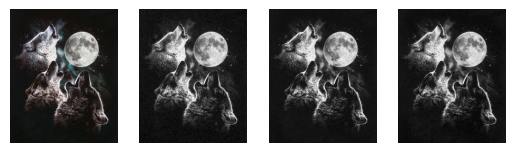

In [ ]:
# Plot the three channels of the image
pylab.figure()
pylab.subplot(1,4,1); pylab.axis('off'); pylab.imshow(img)
pylab.gray()
pylab.subplot(1,4,2); pylab.axis('off'); pylab.imshow(img[:,:,0])
pylab.subplot(1,4,3); pylab.axis('off'); pylab.imshow(img[:,:,1])
pylab.subplot(1,4,4); pylab.axis('off'); pylab.imshow(img[:,:,2])
pylab.savefig(os.path.join(figures_path, 't6q2_1.png'))

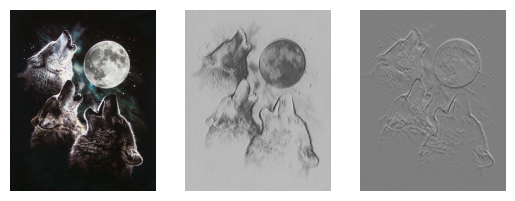

In [ ]:
# Plot original image and first and second components of conv output
pylab.figure()
pylab.subplot(1,3,1); pylab.axis('off'); pylab.imshow(img)
pylab.gray()
pylab.subplot(1,3,2); pylab.axis('off'); pylab.imshow(conv[0,:,:])
pylab.subplot(1,3,3); pylab.axis('off'); pylab.imshow(conv[1,:,:])
pylab.savefig(os.path.join(figures_path, 't6q2_2.png'))

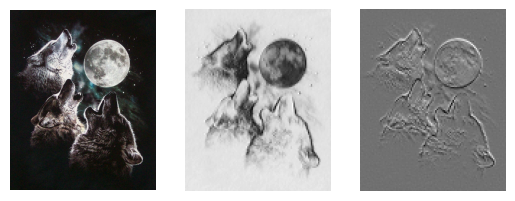

In [ ]:
# Plot original image and first and second component of pooling output
pylab.figure()
pylab.subplot(1,3,1); pylab.axis('off'); pylab.imshow(img)
pylab.gray()
pylab.subplot(1,3,2); pylab.axis('off'); pylab.imshow(pool[0,:,:])
pylab.subplot(1,3,3); pylab.axis('off'); pylab.imshow(pool[1,:,:])
pylab.savefig(os.path.join(figures_path, 't6q2_3.png'))

# Qn3a)

In [2]:
import os
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [4]:
# Load and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.28MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 129kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
# Build Model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = nn.Conv2d(1,25,9,padding=0)
    self.pool = nn.MaxPool2d(4,4)
    self.flatten = nn.Flatten()
    self.dense = nn.Linear(25 * 5 * 5, 10)
## self.conv: 1 input channel, 25 output channels, 9x9 kernel size, no padding
## self.pool: maxpooling, 4x4 kernel size, 4x4 stride
## self.flatten: flattens 2D output into a 1D tensor
## self.dense: 25 * 5 * 5 (derived from output of pooling layer), 10 output features

  def forward(self, x):
    conv = F.relu(self.conv(x))
    pool = self.pool(conv)
    flatten = self.flatten(pool)
    out = F.softmax(self.dense(flatten),dim=1)
    return conv, pool, out

model = MyModel()

In [7]:
# Optimizer and Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
"""
- CrossEntropyLoss for classification, output of model is expected to be logits
for each class, and the function computes softmax fof the scores to get
probabilities
"""
"""
- SGD is an optimization algorithm
- model.parameters() represents all trainable parameters of the model
- lr is the learning rate, the smaller the learning rate, the slower the
convergence but more accurate results
- momentum helps to accelerate gradients in the right directions, leading to
faster convergence, value is between 0 and 1
- weight_decay is the regularisation term that adds penalty to the loss to
prevent overfitting, penalty is based on the magnitude of the weights \
(L2 penalty)
"""

In [9]:
# Train and Test the model
EPOCHS = 50
test_acc = []
print("Training...")
for epoch in range(EPOCHS):
  model.train() # set the model to training mode, so that dropout and batch normalisation is done
  total_loss = 0
  correct = 0
  for batch_idx, (data,target) in enumerate(train_loader):
    optimizer.zero_grad()
    _,_,output = model(data)
    loss = criterion(output,target)
    loss.backward() # backpropagate the error
    optimizer.step()  # update the model weights
    total_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

  train_accuracy = 100 * correct / len(train_loader.dataset)

  model.eval()  # set the model to evaluation mode
  test_loss = 0
  correct = 0
  with torch.no_grad(): # ensure gradients are not computed during testing phase
    for data, target in test_loader:
      _,_,output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_accuracy = 100 * correct / len(test_loader.dataset)
  test_acc.append(test_accuracy)
  print(f"Epoch {epoch+1}, Loss: {total_loss/len(test_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

Training...
Epoch 1, Loss: 12.5438, Train Accuracy: 41.83%, Test Loss: 1.9562, Test Accuracy: 62.45%
Epoch 2, Loss: 11.1696, Train Accuracy: 64.59%, Test Loss: 1.8332, Test Accuracy: 66.52%
Epoch 3, Loss: 10.6855, Train Accuracy: 70.21%, Test Loss: 1.7471, Test Accuracy: 75.65%
Epoch 4, Loss: 10.3072, Train Accuracy: 76.14%, Test Loss: 1.6810, Test Accuracy: 83.50%
Epoch 5, Loss: 9.8655, Train Accuracy: 84.40%, Test Loss: 1.6358, Test Accuracy: 85.64%
Epoch 6, Loss: 9.7143, Train Accuracy: 85.43%, Test Loss: 1.6217, Test Accuracy: 86.32%
Epoch 7, Loss: 9.6456, Train Accuracy: 85.91%, Test Loss: 1.6133, Test Accuracy: 86.67%
Epoch 8, Loss: 9.6011, Train Accuracy: 86.30%, Test Loss: 1.6074, Test Accuracy: 86.89%
Epoch 9, Loss: 9.5691, Train Accuracy: 86.57%, Test Loss: 1.6030, Test Accuracy: 87.17%
Epoch 10, Loss: 9.5427, Train Accuracy: 86.80%, Test Loss: 1.5988, Test Accuracy: 87.28%
Epoch 11, Loss: 9.2812, Train Accuracy: 92.43%, Test Loss: 1.5342, Test Accuracy: 94.88%
Epoch 12, Loss

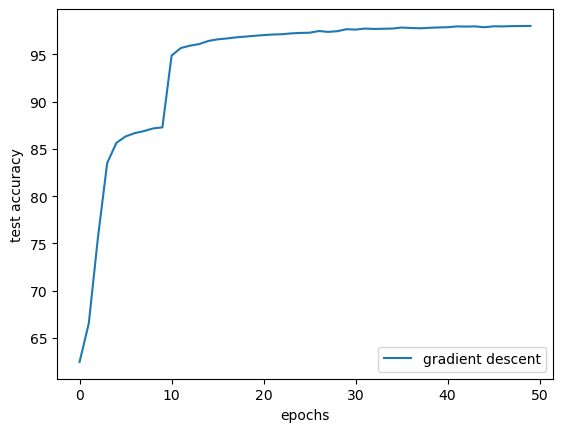

In [10]:
# Plotting test accuracy
plt.figure()
plt.plot(np.arange(EPOCHS), test_acc, label='gradient descent')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend(loc='lower right')
plt.savefig(os.path.join(figures_path,'t6q3_1.png'))

(25, 1, 9, 9)


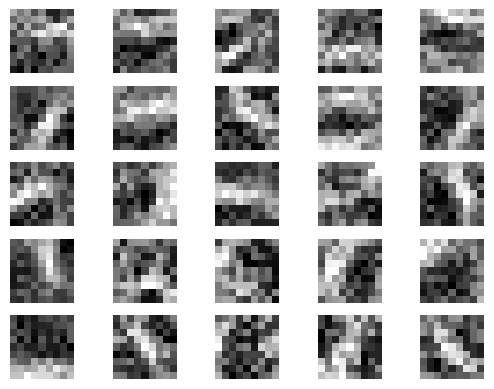

In [11]:
# Get filters learned at conv layer
filters_conv = model.conv.weight.data.cpu().numpy()
print(filters_conv.shape)

# Displaying the filters
plt.figure()
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  plt.imshow(filters_conv[i,0,:,:], cmap='gray')
plt.savefig(os.path.join(figures_path,'t6q3_2.png'))

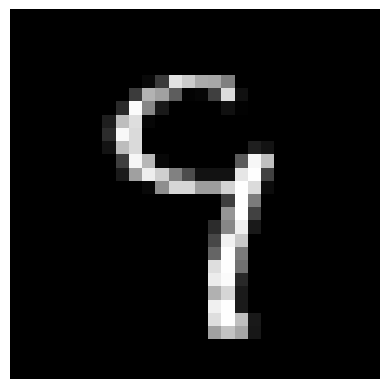

In [13]:
# Select and show a random sample
seed=2
np.random.seed(seed)
ind = np.random.randint(0,2000)
x,_ = test_dataset[ind]
conv, pool, _ = model(x.unsqueeze(0))

# Displaying the random sample
plt.figure()
plt.axis('off')
plt.imshow(x.squeeze().numpy(), cmap='gray')
plt.savefig(os.path.join(figures_path,'t6q3_3.png'))

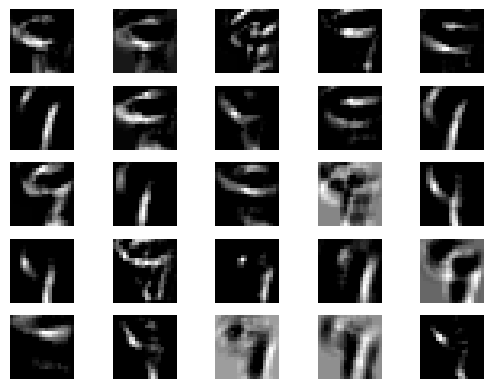

In [14]:
# Show feature maps at conv
conv = conv.data.cpu().numpy()
plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(conv[0,i,:,:], cmap='gray')
plt.savefig(os.path.join(figures_path,'t6q3_4.png'))

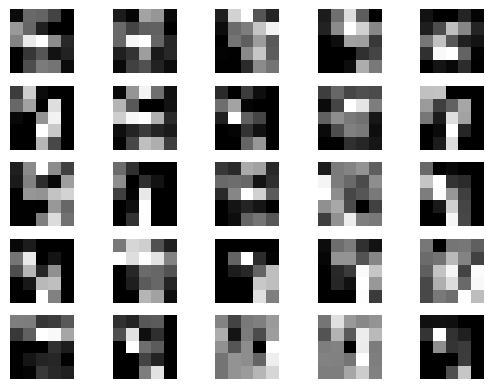

In [15]:
# Show feature maps at pooling
pool = pool.data.cpu().numpy()
plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(pool[0,i,:,:], cmap='gray')
plt.savefig(os.path.join(figures_path,'t6q3_5.png'))

# Qn3b)

In [16]:
# Load and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128)

In [17]:
# Build Model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = nn.Conv2d(1,25,9,padding=0)
    self.pool = nn.MaxPool2d(4,4)
    self.flatten = nn.Flatten()
    self.dense = nn.Linear(25 * 5 * 5, 10)
## self.conv: 1 input channel, 25 output channels, 9x9 kernel size, no padding
## self.pool: maxpooling, 4x4 kernel size, 4x4 stride
## self.flatten: flattens 2D output into a 1D tensor
## self.dense: 25 * 5 * 5 (derived from output of pooling layer), 10 output features

  def forward(self, x):
    conv = F.relu(self.conv(x))
    pool = self.pool(conv)
    flatten = self.flatten(pool)
    out = F.softmax(self.dense(flatten),dim=1)
    return conv, pool, out

model = MyModel()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.000001)

In [19]:
# Train and Test the model
EPOCHS = 50
test_acc = []
print("Training...")
for epoch in range(EPOCHS):
  model.train() # set the model to training mode, so that dropout and batch normalisation is done
  total_loss = 0
  correct = 0
  for batch_idx, (data,target) in enumerate(train_loader):
    optimizer.zero_grad()
    _,_,output = model(data)
    loss = criterion(output,target)
    loss.backward() # backpropagate the error
    optimizer.step()  # update the model weights
    total_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

  train_accuracy = 100 * correct / len(train_loader.dataset)

  model.eval()  # set the model to evaluation mode
  test_loss = 0
  correct = 0
  with torch.no_grad(): # ensure gradients are not computed during testing phase
    for data, target in test_loader:
      _,_,output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_accuracy = 100 * correct / len(test_loader.dataset)
  test_acc.append(test_accuracy)
  print(f"Epoch {epoch+1}, Loss: {total_loss/len(test_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

Training...
Epoch 1, Loss: 13.5964, Train Accuracy: 14.09%, Test Loss: 2.2777, Test Accuracy: 19.60%
Epoch 2, Loss: 13.4168, Train Accuracy: 25.38%, Test Loss: 2.2363, Test Accuracy: 32.58%
Epoch 3, Loss: 13.0653, Train Accuracy: 38.57%, Test Loss: 2.1571, Test Accuracy: 46.67%
Epoch 4, Loss: 12.4963, Train Accuracy: 50.53%, Test Loss: 2.0503, Test Accuracy: 54.41%
Epoch 5, Loss: 11.9319, Train Accuracy: 56.73%, Test Loss: 1.9716, Test Accuracy: 57.51%
Epoch 6, Loss: 11.5515, Train Accuracy: 59.61%, Test Loss: 1.9094, Test Accuracy: 64.33%
Epoch 7, Loss: 11.2216, Train Accuracy: 65.50%, Test Loss: 1.8664, Test Accuracy: 66.34%
Epoch 8, Loss: 11.0289, Train Accuracy: 66.38%, Test Loss: 1.8424, Test Accuracy: 66.95%
Epoch 9, Loss: 10.9141, Train Accuracy: 66.81%, Test Loss: 1.8270, Test Accuracy: 67.24%
Epoch 10, Loss: 10.8324, Train Accuracy: 67.10%, Test Loss: 1.8137, Test Accuracy: 67.54%
Epoch 11, Loss: 10.6808, Train Accuracy: 71.39%, Test Loss: 1.7793, Test Accuracy: 74.38%
Epoch 1

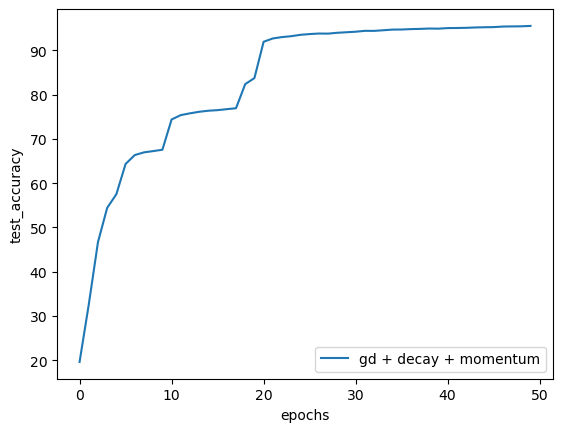

In [20]:
# Plotting test accuracy
plt.figure()
plt.plot(np.arange(EPOCHS), test_acc, label='gd + decay + momentum')
plt.xlabel('epochs')
plt.ylabel('test_accuracy')
plt.legend(loc = 'lower right')
plt.savefig(os.path.join(figures_path,'t6q3_6.png'))